# Predcition of Hospital Admission Related to Cold with Cough

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to cold with cough (cough_cold). We, then, analyse whether prescribing antibiotics is based on the risk of hospital admission or not by building logistic regression (LR) and random forest (RF) models.

In [47]:
import pandas as pd
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [48]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [49]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [50]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'cough_cold_date_'+str(i), 'cough_cold_ab_date_'+str(i), 'cough_cold_ab_type_'+str(i),
                   'incdt_cough_cold_date_'+str(i), 'admitted_cough_cold_date_'+str(i), 'sgss_gp_cov_cough_cold_date_'+str(i)]]
    
    #drop rows with no cough_cold reord
    datum = datum[datum['cough_cold_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with cough_cold_i
    datum = datum[datum['sgss_gp_cov_cough_cold_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'cough_cold_date_'+str(i): 'cough_cold_date', 'cough_cold_ab_date_'+str(i): 'cough_cold_ab_date', 
                           'cough_cold_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_cough_cold_date_'+str(i): 'incdt_cough_cold_date', 'incdt_cough_cold_type_'+str(i): 'incdt_cough_cold_type',
                           'admitted_cough_cold_date_'+str(i): 'admitted_cough_cold_date',
                           'sgss_gp_cov_cough_cold_date_'+str(i): 'sgss_gp_cov_cough_cold_date'},
                inplace=True)
    
    return datum

In [51]:
#summary table of baseline characteristics
def make_summary_table(infection, infection_type, prob_pred):

    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']].columns)
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_tot = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit']]], axis=1)

    #calculate sums
    summary_table = prob_pred_enc_tot.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_tot.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_tot.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [52]:
#summary table of baseline characteristics
def make_summary_table_deciles(infection, infection_type, prob_pred_enc_lr_rf):
    #calculate sums
    summary_table = prob_pred_enc_lr_rf.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_lr_rf.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_lr_rf.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_deciles_'+infection+'_'+infection_type+'.csv', index=False)

In [53]:
def cox_build(infection, infection_type, data, data_no_abs): #data_cough_cold_incdt, data_cough_cold_no_abs_incdt
    #randomly splitting data into training (%75) and testing (%25)
    data_dev, data_val = train_test_split(data_no_abs, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_dev,
            duration_col='duration_cough_cold_admitted',
            event_col='event_cough_cold_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics
    #predict cumulative hazard in day 30 in train dataset
    prob_pred = cph.predict_cumulative_hazard(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit']]).loc[[30]].T
    prob_pred.columns = ['pred']
    #prob_pred_cough_cold_no_abs_incdt

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred['bins'] = pd.qcut(prob_pred['pred'], 10)
    #prob_pred

    ##add a column for prescribed antibiotics
    prob_pred = pd.concat([prob_pred, data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred

    ###needed for figures
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_bin = prob_pred.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_prob_mean', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_bin['bins'] = prob_pred_bin['bins'].astype(str)
    #prob_pred_cough_cold_no_abs_incdt_bin
    prob_pred_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_bin_'+infection+'_'+infection_type+'.csv', index=False)

    #plot
    plt.figure(figsize=(10,7))
    sns.lineplot(x='bins', y='ab_prob_mean', data=prob_pred_bin, marker='o', markersize=10)
    g = sns.lineplot(x="bins", data=prob_pred_bin, y="ab_prob_mean", marker='*', linestyle='--', markersize=10)
    plt.ylim(0)#, data.pred_mean_train.max() + data.pred_mean_train.max()/3)
    plt.xlim(0)#, data.ab_prob_mean_train.max() + data.ab_prob_mean_train.max()/3)
    plt.setp(g.collections, alpha=.5) #alpha for markers
    plt.setp(g.lines, alpha=.5) #alpha for line
    plt.xlabel('Decile', fontsize=14)
    plt.ylabel('Mean probability of prescribing antibiotic', fontsize=14)
    plt.gca().set_xticks(np.arange(0,10,1), minor=True)
    plt.grid(b=True, which='major', color='k', linestyle=':', alpha=0.5)
    plt.grid(which='minor', color='k', linestyle=':', alpha=0.5)
    plt.xticks(prob_pred_bin.bins, rotation=90)
    # plt.legend([],[], frameon=False)
    # plt.savefig('../output/aggregate_ab_prob/aggregate_ab_prob_incdt.jpg')
    plt.show()

    return prob_pred, prob_pred_bin

In [54]:
def lr_rf_build_risk_deciles(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['bins']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['bins']].columns)
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    ##building lr model
    lr = sm.Logit(endog=data_enc_dev_y, exog=data_enc_dev_x)
    lr = lr.fit(disp=0)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict(data_enc_dev_x)
    lr_pred_val = lr.predict(data_enc_val_x)

    ##building rf model
    rf = RandomForestClassifier(n_estimators=200, max_leaf_nodes=30, max_depth=20)
    rf.fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities to rf model
    rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #calculate aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    #save and print aurocs
    auroc_lr = pd.DataFrame([[auroc_lr_dev, auroc_lr_val]], columns=['auroc_dev', 'auroc_val'])
    auroc_lr.to_csv('../output/hospitalisation_prediction_'+infection+'/auroc_lr_'+infection+'_'+infection_type+'.csv')
    print('\nAUROC of LR for deciles with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    print('AUROC of RF for deciles with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    #print summary of LR model
    lr_coef = pd.DataFrame({"OR": lr.params, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    lr_coef = np.exp(lr_coef)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_deciles_'+infection+'_'+infection_type+'.csv')
    print('LR coefficients:\n %s'%(lr_coef))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    #print feature importance of RF model
    rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_deciles_'+infection+'_'+infection_type+'.csv')
    print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR and RF models with deciles", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_deciles_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val

In [55]:
def lr_rf_build_risk_riskfactors(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']].columns)
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)#, random_state=42)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    ##building lr model
    lr = sm.Logit(endog=data_enc_dev_y, exog=data_enc_dev_x)
    lr = lr.fit(disp=0)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict(data_enc_dev_x)
    lr_pred_val = lr.predict(data_enc_val_x)

    ##building rf model
    rf = RandomForestClassifier(n_estimators=200, max_leaf_nodes=30, max_depth=20)
    rf.fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities to rf model
    rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #print aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    print('\nAUROC of LR for risk factors with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    print('AUROC of RF for risk factors with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    #print summary of LR model
    lr_coef = pd.DataFrame({"OR": lr.params, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    lr_coef = np.exp(lr_coef)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_'+infection+'_'+infection_type+'.csv')
    print('LR coefficients:\n %s'%(lr_coef))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    #print feature importance of RF model
    rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_'+infection+'_'+infection_type+'.csv')
    print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR and RF models with risk factors", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_riskfactors_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val

In [56]:
def calibration_rf_lr(infection, infection_type, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val):
    ##calibration for RF
    rf_prob_pred_dev = pd.DataFrame(data=rf_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    rf_prob_pred_dev['bins'] = pd.qcut(rf_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    rf_prob_pred_dev = pd.merge(rf_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    rf_prob_pred_dev_groupby_bin = rf_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    rf_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    rf_prob_pred_dev_groupby_bin['ab_binary_proportion'] = rf_prob_pred_dev_groupby_bin['ab_binary_sum']/rf_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    rf_prob_pred_val = pd.DataFrame(data=rf_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    rf_prob_pred_val['bins'] = pd.qcut(rf_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    rf_prob_pred_val = pd.merge(rf_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    rf_prob_pred_val_groupby_bin = rf_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    rf_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    rf_prob_pred_val_groupby_bin['ab_binary_proportion'] = rf_prob_pred_val_groupby_bin['ab_binary_sum']/rf_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(rf_prob_pred_dev_groupby_bin.pred_mean, rf_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#8D576D', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(rf_prob_pred_val_groupby_bin.pred_mean, rf_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#eb91b7', linestyle='dashed', marker='v', alpha=0.9)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of RF model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#8D576D', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#eb91b7', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.9)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_rf_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

    ##calibration for LR
    lr_prob_pred_dev = pd.DataFrame(data=lr_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_dev['bins'] = pd.qcut(lr_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_dev = pd.merge(lr_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_dev_groupby_bin = lr_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_dev_groupby_bin['ab_binary_proportion'] = lr_prob_pred_dev_groupby_bin['ab_binary_sum']/lr_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    lr_prob_pred_val = pd.DataFrame(data=lr_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_val['bins'] = pd.qcut(lr_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_val = pd.merge(lr_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_val_groupby_bin = lr_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_val_groupby_bin['ab_binary_proportion'] = lr_prob_pred_val_groupby_bin['ab_binary_sum']/lr_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(lr_prob_pred_dev_groupby_bin.pred_mean, lr_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#408678', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(lr_prob_pred_val_groupby_bin.pred_mean, lr_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#6ce0c9', linestyle='dashed', marker='v', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of LR model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#408678', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#6ce0c9', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.6)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_lr_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

## 1- data preparation

In [57]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_cough_cold.csv.gz')

In [58]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [59]:
#process 20 cough_colds and concatenate them 
data_cough_cold_1 = proc_infec_data(data,1)
data_cough_cold_2 = proc_infec_data(data,2)
data_cough_cold_3 = proc_infec_data(data,3)
data_cough_cold_4 = proc_infec_data(data,4)
data_cough_cold_5 = proc_infec_data(data,5)
data_cough_cold_6 = proc_infec_data(data,6)
data_cough_cold_7 = proc_infec_data(data,7)
data_cough_cold_8 = proc_infec_data(data,8)
data_cough_cold_9 = proc_infec_data(data,9)
data_cough_cold_10 = proc_infec_data(data,10)
data_cough_cold_11 = proc_infec_data(data,11)
data_cough_cold_12 = proc_infec_data(data,12)
data_cough_cold_13 = proc_infec_data(data,13)
data_cough_cold_14 = proc_infec_data(data,14)
data_cough_cold_15 = proc_infec_data(data,15)
data_cough_cold_16 = proc_infec_data(data,16)
data_cough_cold_17 = proc_infec_data(data,17)
data_cough_cold_18 = proc_infec_data(data,18)
data_cough_cold_19 = proc_infec_data(data,19)
data_cough_cold_20 = proc_infec_data(data,20)

data_cough_cold = pd.concat([data_cough_cold_1, data_cough_cold_2, data_cough_cold_3, data_cough_cold_4, data_cough_cold_5, data_cough_cold_6, data_cough_cold_7, data_cough_cold_8, data_cough_cold_9, data_cough_cold_10, data_cough_cold_11, data_cough_cold_12, data_cough_cold_13, data_cough_cold_14, data_cough_cold_15, data_cough_cold_16, data_cough_cold_17, data_cough_cold_18, data_cough_cold_19, data_cough_cold_20])
data_cough_cold.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [60]:
##add variable season
#convert data types
data_cough_cold['cough_cold_date'] = data_cough_cold['cough_cold_date'].astype('datetime64[ns]')
data_cough_cold['admitted_cough_cold_date'] = data_cough_cold['admitted_cough_cold_date'].astype('datetime64[ns]')
data_cough_cold.died_date = data_cough_cold.died_date.astype('datetime64[ns]')
data_cough_cold.deregistered_date = data_cough_cold.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_cough_cold['date'] = data_cough_cold['cough_cold_date'] 
data_cough_cold['date'] = data_cough_cold['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_cough_cold with today's date in year and month
data_cough_cold = data_cough_cold[data_cough_cold['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_cough_cold = data_cough_cold[data_cough_cold['date'] != last_1_month_date_y_m]
data_cough_cold = data_cough_cold[data_cough_cold['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of cough_cold records
data_cough_cold['season'] = np.nan
data_cough_cold['date_month'] = pd.DatetimeIndex(data_cough_cold['date']).month

conditions = [
    (data_cough_cold['date_month'] >= 3) & (data_cough_cold['date_month'] <= 5),
    (data_cough_cold['date_month'] >= 6) & (data_cough_cold['date_month'] <= 8),
    (data_cough_cold['date_month'] >= 9) & (data_cough_cold['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_cough_cold['season'] = np.select(conditions, choices, default='winter')

In [61]:
#add variable time period
data_cough_cold.loc[(data_cough_cold['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_cough_cold.loc[((data_cough_cold['date'] >= '2020-01') & (data_cough_cold['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_cough_cold.loc[(data_cough_cold['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

In [62]:
data_cough_cold['date'].max()

'2023-03'

#### event and duration

In [63]:
#scenario 1
#not hosped (nothing happened)
data_cough_cold.loc[data_cough_cold['admitted_cough_cold_date'].isnull(), 'event_cough_cold_admitted'] = 0

In [64]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_cough_cold['delta_cough_cold_admitted'] = (data_cough_cold['admitted_cough_cold_date'] - data_cough_cold['cough_cold_date']).dt.days
data_cough_cold.loc[((data_cough_cold['delta_cough_cold_admitted'] >= 0) & (data_cough_cold['delta_cough_cold_admitted'] <= 30)), 'event_cough_cold_admitted'] = 1

#scenario 2
#drop whoever was admitted before cough_cold consultation, i.e. negative value for delta_cough_cold_admitted
data_cough_cold = data_cough_cold[~(data_cough_cold['delta_cough_cold_admitted'] < 0)]

In [65]:
#scenario 3
#censor died patients
data_cough_cold['delta_admitted_died'] = (data_cough_cold['died_date'] - data_cough_cold['admitted_cough_cold_date']).dt.days
data_cough_cold.loc[data_cough_cold['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_cough_cold.loc[((data_cough_cold['delta_admitted_died'] >= 0) & (data_cough_cold['delta_admitted_died'] <= 30)), 'event_cough_cold_admitted'] = 0

#scenario 3
#censor deregistered patients
data_cough_cold['delta_admitted_deregistered'] = (data_cough_cold['deregistered_date'] - data_cough_cold['admitted_cough_cold_date']).dt.days
data_cough_cold.loc[data_cough_cold['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_cough_cold.loc[((data_cough_cold['delta_admitted_deregistered'] > 0) & (data_cough_cold['delta_admitted_deregistered'] <= 30)), 'event_cough_cold_admitted'] = 0

#agg scenario 3s
data_cough_cold['delta_admitted_died_deregistered'] = data_cough_cold['delta_admitted_deregistered'].combine_first(data_cough_cold['delta_admitted_died'])
data_cough_cold.loc[data_cough_cold['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [66]:
#scenario 1
#any other patients (nothing happened)
data_cough_cold['event_cough_cold_admitted'] = data_cough_cold['event_cough_cold_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_cough_cold['duration_cough_cold_admitted'] = data_cough_cold['delta_cough_cold_admitted'].combine_first(data_cough_cold['delta_admitted_died_deregistered'])
data_cough_cold['duration_cough_cold_admitted'] = data_cough_cold['duration_cough_cold_admitted'].replace(np.NaN, 30)
data_cough_cold.loc[(data_cough_cold['duration_cough_cold_admitted'] > 30), 'duration_cough_cold_admitted'] = 30

#give value 1 to event_cough_cold_admitted if duration_cough_cold_admitted is greater or equal to 0 and less than 30
data_cough_cold.loc[((data_cough_cold['duration_cough_cold_admitted'] >= 0) & (data_cough_cold['duration_cough_cold_admitted'] < 30)), 'event_cough_cold_admitted'] = 1

#drop any rows with value 0 in duration column
data_cough_cold = data_cough_cold[~(data_cough_cold['duration_cough_cold_admitted'] == 0)]

In [67]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_cough_cold.loc[((data_cough_cold['delta_cough_cold_admitted'] > 0) & (data_cough_cold['delta_cough_cold_admitted'] < 30)), 'event_cough_cold_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [68]:
#drop anybody with age less than 18 or 0!
data_cough_cold = data_cough_cold[~(data_cough_cold['age'] < 18)] 
data_cough_cold['age'][data_cough_cold['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_cough_cold = data_cough_cold[data_cough_cold['age_cat'] != '0-4']
data_cough_cold = data_cough_cold[data_cough_cold['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_cough_cold['bmi'][data_cough_cold['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_cough_cold['bmi'] = data_cough_cold['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_cough_cold['antibacterial_brit'][data_cough_cold['antibacterial_brit'] < 0] = np.nan

In [69]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_cough_cold = data_cough_cold.replace({"sex": dict_sex})
data_cough_cold = data_cough_cold.replace({"smoking": dict_smoking})

In [70]:
#drop rows with missing region
if ('region' in data_cough_cold.columns) and (data_cough_cold['region'].isnull().sum() > 0):
   data_cough_cold = data_cough_cold[data_cough_cold['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_cough_cold.columns) and (data_cough_cold['antibacterial_brit'].isnull().sum() > 0):
    data_cough_cold['antibacterial_brit'] = data_cough_cold['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_cough_cold.columns) and (data_cough_cold['ethnicity'].isnull().sum() > 0):
    data_cough_cold['ethnicity'] = data_cough_cold['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking' in data_cough_cold.columns) and (data_cough_cold['smoking'].isnull().sum() > 0):
    data_cough_cold['smoking'] = data_cough_cold['smoking'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_cough_cold.columns) and (data_cough_cold['imd'].isnull().sum() > 0):
    data_cough_cold['imd'] = data_cough_cold['imd'].fillna(0)

In [71]:
#missing values of bmi assign 5 and 0; categorise bmi
data_cough_cold['bmi_cat'] = 5

for idx, x in enumerate(data_cough_cold['bmi_cat']):
    if data_cough_cold.iat[idx, data_cough_cold.columns.get_loc('bmi')] >= 30:
        data_cough_cold.iat[idx, data_cough_cold.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_cough_cold.iat[idx, data_cough_cold.columns.get_loc('bmi')] >= 25) and (data_cough_cold.iat[idx, data_cough_cold.columns.get_loc('bmi')] < 30):
        data_cough_cold.iat[idx, data_cough_cold.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_cough_cold.iat[idx, data_cough_cold.columns.get_loc('bmi')] >= 18.5) and (data_cough_cold.iat[idx, data_cough_cold.columns.get_loc('bmi')] < 25):
        data_cough_cold.iat[idx, data_cough_cold.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_cough_cold.iat[idx, data_cough_cold.columns.get_loc('bmi')] < 18.5:
        data_cough_cold.iat[idx, data_cough_cold.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_cough_cold.columns) and (data_cough_cold['bmi_cat'].isnull().sum() > 0):
    data_cough_cold['bmi_cat'] = data_cough_cold['bmi_cat'].fillna(0)

In [72]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_cough_cold.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_cough_cold['ab_type_cat'] = np.where(data_cough_cold['ab_type'].isin(ab_series[mask].index),'other',data_cough_cold['ab_type'])
#assign no to non ab users
data_cough_cold.loc[data_cough_cold['cough_cold_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_cough_cold['ab_type_cat'] = data_cough_cold['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [73]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'mixed', 3.0: 'asian', 4.0: 'black', 5.0: 'other', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_cough_cold = data_cough_cold.replace({"sex": dict_sex})
data_cough_cold = data_cough_cold.replace({"ethnicity": dict_ethnicity})
data_cough_cold = data_cough_cold.replace({"smoking": dict_smoking})
data_cough_cold = data_cough_cold.replace({"imd": dict_imd})
data_cough_cold = data_cough_cold.replace({"bmi_cat": dict_bmi})
data_cough_cold = data_cough_cold.replace({"flu_vaccine": dict_flu})
data_cough_cold = data_cough_cold.replace({"region": dict_region})
data_cough_cold = data_cough_cold.replace({"age_cat": dict_age})
data_cough_cold = data_cough_cold.replace({"ab_type_cat": dict_ab_type})

In [74]:
data_cough_cold.ethnicity.value_counts('NA')

white      0.601549
unknown    0.248970
other      0.075328
asian      0.074153
Name: ethnicity, dtype: float64

In [75]:
data_cough_cold.smoking.value_counts('NA')

unknown         0.412823
smoker          0.392796
never_smoked    0.130651
ex_smoker       0.063730
Name: smoking_status, dtype: float64

In [76]:
data_cough_cold.bmi_cat.value_counts('NA')

obese             0.517985
unknown           0.256580
overweight        0.112647
healthy_weight    0.081508
underweight       0.031280
Name: bmi_cat, dtype: float64

### 2-5- categorising and assigning max value for continuous variables

In [77]:
#categorise CCI
data_cough_cold['CCI_cat'] = pd.cut(data_cough_cold['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_cough_cold['antibacterial_brit'].clip(0, data_cough_cold['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

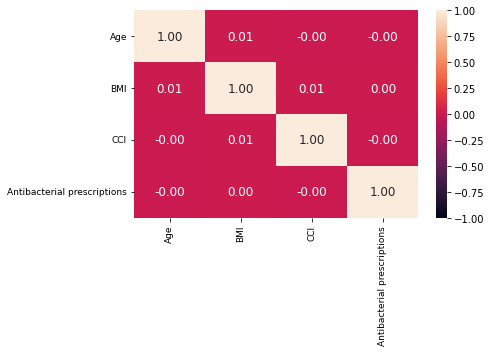

In [78]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_cough_cold[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_cough_cold/corr_cough_cold.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [79]:
data_cough_cold = data_cough_cold[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 
                                   'antibacterial_brit', 'cough_cold_ab_date', 'ab_type_cat', 'incdt_cough_cold_date', 'date', 'period',
                                   'event_cough_cold_admitted', 'duration_cough_cold_admitted'
                                    ]]

In [80]:
#switch variable cough_cold_ab_date into a binary variable
data_cough_cold[['ab_binary']] = data_cough_cold[['cough_cold_ab_date']].where(data_cough_cold[['cough_cold_ab_date']].isnull(), 1).fillna(0).astype(int)
#incident and prevalent infection 
data_cough_cold_incdt = data_cough_cold[data_cough_cold['incdt_cough_cold_date'] == 0]
data_cough_cold_prevl = data_cough_cold[data_cough_cold['incdt_cough_cold_date'] == 1]

#no antibiotics and incident hospital admission
data_cough_cold_no_abs_incdt = data_cough_cold_incdt[data_cough_cold_incdt['ab_binary'] == 0]
#with antibiotics and incident hospital admission
data_cough_cold_abs_incdt = data_cough_cold_incdt[data_cough_cold_incdt['ab_binary'] == 1]

#no antibiotics and prevalent hospital admission
data_cough_cold_no_abs_prevl = data_cough_cold_prevl[data_cough_cold_prevl['ab_binary'] == 0]
#with antibiotics and prevalent hospital admission
data_cough_cold_abs_prevl = data_cough_cold_prevl[data_cough_cold_prevl['ab_binary'] == 1]

In [81]:
##subcohorts for stratification by period
#incident and prevalent infection stratified by time period categories
data_cough_cold_incdt_prepandemic = data_cough_cold_incdt[data_cough_cold_incdt['period'] == 'prepandemic']
data_cough_cold_incdt_during_pandemic = data_cough_cold_incdt[(data_cough_cold_incdt['period'] == 'during_pandemic')]
data_cough_cold_incdt_post_2nd_lockdown = data_cough_cold_incdt[data_cough_cold_incdt['period'] == 'post_2nd_lockdown']
data_cough_cold_prevl_prepandemic = data_cough_cold_prevl[data_cough_cold_prevl['period'] == 'prepandemic']
data_cough_cold_prevl_during_pandemic = data_cough_cold_prevl[(data_cough_cold_prevl['period'] == 'during_pandemic')]
data_cough_cold_prevl_post_2nd_lockdown = data_cough_cold_prevl[data_cough_cold_prevl['period'] == 'post_2nd_lockdown']

#no antibiotics and incident hospital admission
data_cough_cold_no_abs_incdt_prepandemic = data_cough_cold_incdt_prepandemic[data_cough_cold_incdt_prepandemic['ab_binary'] == 0]
data_cough_cold_no_abs_incdt_during_pandemic = data_cough_cold_incdt_during_pandemic[data_cough_cold_incdt_during_pandemic['ab_binary'] == 0]
data_cough_cold_no_abs_incdt_post_2nd_lockdown = data_cough_cold_incdt_post_2nd_lockdown[data_cough_cold_incdt_post_2nd_lockdown['ab_binary'] == 0]
data_cough_cold_no_abs_prevl_prepandemic = data_cough_cold_prevl_prepandemic[data_cough_cold_prevl_prepandemic['ab_binary'] == 0]
data_cough_cold_no_abs_prevl_during_pandemic = data_cough_cold_prevl_during_pandemic[data_cough_cold_prevl_during_pandemic['ab_binary'] == 0]
data_cough_cold_no_abs_prevl_post_2nd_lockdown = data_cough_cold_prevl_post_2nd_lockdown[data_cough_cold_prevl_post_2nd_lockdown['ab_binary'] == 0]

In [82]:
#store data for plotting hosp admission counts and percentages
%store data_cough_cold
# save data
data_cough_cold.to_csv('../output/hospitalisation_prediction_cough_cold/data_cough_cold.csv')

Stored 'data_cough_cold' (DataFrame)


## 5- modelling of antibiotics prediction based on risk of hospital admission
### 5-0- summary tables

In [83]:
#make summary tables
make_summary_table('cough_cold', 'no_abs_incdt', data_cough_cold_no_abs_incdt)
make_summary_table('cough_cold', 'abs_incdt', data_cough_cold_abs_incdt)
make_summary_table('cough_cold', 'no_abs_prevl', data_cough_cold_no_abs_prevl)
make_summary_table('cough_cold', 'abs_prevl', data_cough_cold_abs_prevl)

### 5-1- incident

<lifelines.CoxPHFitter: fitted with 107448 total observations, 106780 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 107448
number of events observed = 668
   partial log-likelihood = -7712.40
         time fit was run = 2023-06-29 10:16:38 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.02       1.03       0.12            -0.20             0.25                 0.82                 1.29
CCI_cat[T.medium]               -0.00       1.00       0.13            -0.26             0.25                 0.77                 1.28
CCI_cat[T.high]                  0.02       1.02       0.15            -0.28             0.32                 0.75                 1.38
CCI_cat[T.very_high]             0.09       1.09       0.13            -0.17             0.35                 0.84                 1.42
age_cat[T.25_34]                 0.07       1.08       0.15            -0.21             0.36                 0.81                 1.43
age_cat[T.35_44]                -0.13       0.88       0.15            -0.43             0.17                 0.65                 1.19
age_cat[T.45_54]                -0.06       0.94       0.15            -0.36             0.23                 0.70                 1.26
age_cat[T.55_64]                 0.20       1.22       0.14            -0.08             0.47                 0.92                 1.60
age_cat[T.65_74]                 0.04       1.04       0.15            -0.25             0.33                 0.78                 1.39
age_cat[T.75_more]               0.20       1.22       0.14            -0.08             0.48                 0.92                 1.61
antibacterial_brit               0.01       1.01       0.03            -0.04             0.07                 0.96                 1.07
bmi_cat[T.obese]                -0.14       0.87       0.14            -0.40             0.13                 0.67                 1.14
bmi_cat[T.overweight]           -0.32       0.72       0.18            -0.67             0.02                 0.51                 1.02
bmi_cat[T.underweight]          -0.31       0.73       0.27            -0.83             0.21                 0.43                 1.24
bmi_cat[T.unknown]              -0.19       0.82       0.15            -0.48             0.09                 0.62                 1.10
ethnicity[T.other]               0.13       1.13       0.21            -0.28             0.53                 0.75                 1.71
ethnicity[T.unknown]            -0.02       0.98       0.17            -0.36             0.32                 0.70                 1.38
ethnicity[T.white]               0.21       1.23       0.16            -0.11             0.52                 0.90                 1.68
flu_vaccine[T.yes]              -0.20       0.82       0.14            -0.47             0.08                 0.62                 1.08
imd[T.medium]                   -0.02       0.98       0.12            -0.26             0.22                 0.77                 1.25
imd[T.unaffluent]               -0.11       0.89       0.12            -0.36             0.13                 0.70                 1.14
imd[T.unknown]                  -0.19       0.82       0.20            -0.59             0.21                 0.55                 1.23
imd[T.very_affluent]            -0.12       0.89       0.12            -0.36             0.13                 0.70                 1.14
imd[T.very_unaffluent]          -0.08       0.93       0.12            -0.32             0.16                 0.73                 1.18
region[T.east_midlands]          0.18       1.20     

13065


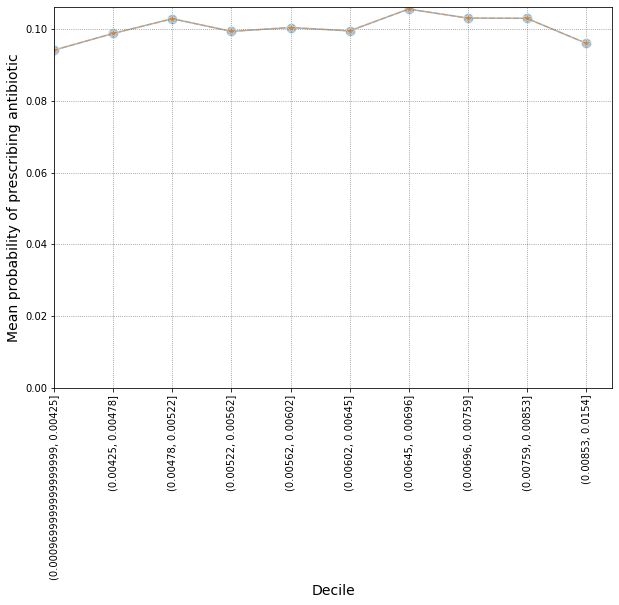


AUROC of LR for deciles with development and validation data: 0.51104 and 0.50621
AUROC of RF for deciles with development and validation data: 0.51104 and 0.50621
LR coefficients:
                                              OR  Lower CI  Upper CI
bins_(0.0009699999999999999, 0.00425]  0.105448  0.099200  0.112091
bins_(0.00425, 0.00478]                0.108649  0.102280  0.115415
bins_(0.00478, 0.00522]                0.116318  0.109703  0.123332
bins_(0.00522, 0.00562]                0.110800  0.104352  0.117646
bins_(0.00562, 0.00602]                0.110268  0.103826  0.117110
bins_(0.00602, 0.00645]                0.109587  0.103199  0.116369
bins_(0.00645, 0.00696]                0.119054  0.112361  0.126146
bins_(0.00696, 0.00759]                0.112797  0.106293  0.119698
bins_(0.00759, 0.00853]                0.113962  0.107401  0.120924
bins_(0.00853, 0.0154]                 0.104373  0.098167  0.110971

RF feature importance:
                                         rf_c

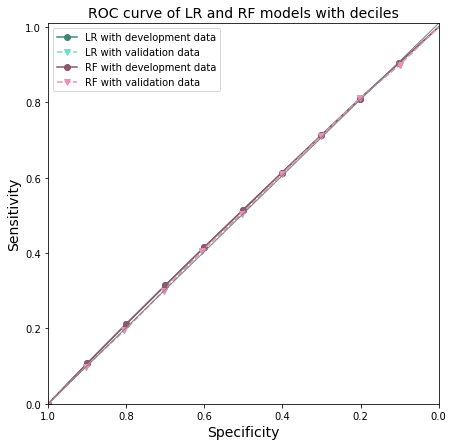

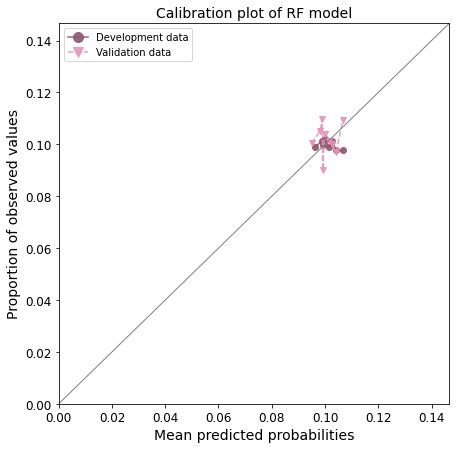

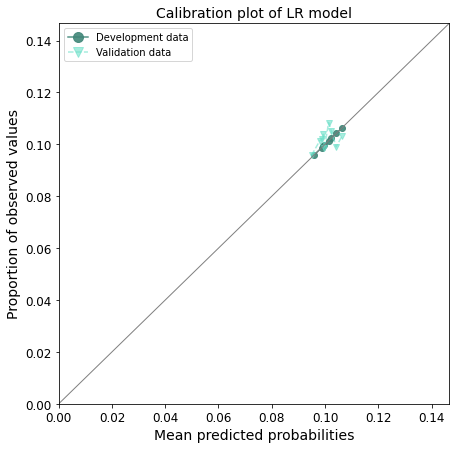


AUROC of LR for risk factors with development and validation data: 0.51845 and 0.49820
AUROC of RF for risk factors with development and validation data: 0.59096 and 0.49862
LR coefficients:
                                    OR  Lower CI  Upper CI
age_cat_15_24                0.881136       NaN       NaN
age_cat_25_34                0.878492       NaN       NaN
age_cat_35_44                0.870088       NaN       NaN
age_cat_45_54                0.883960       NaN       NaN
age_cat_55_64                0.908137       NaN       NaN
age_cat_65_74                0.939755       NaN       NaN
age_cat_75_more              0.856547       NaN       NaN
sex_female                   0.650568       NaN       NaN
sex_male                     0.668961       NaN       NaN
CCI_cat_high                 0.849413       NaN       NaN
CCI_cat_low                  0.819824       NaN       NaN
CCI_cat_medium               0.860303       NaN       NaN
CCI_cat_very_high            0.869351       NaN      

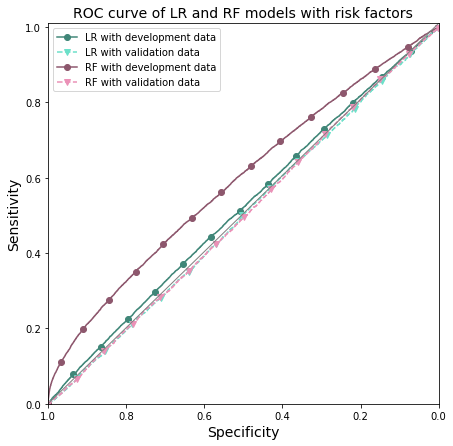

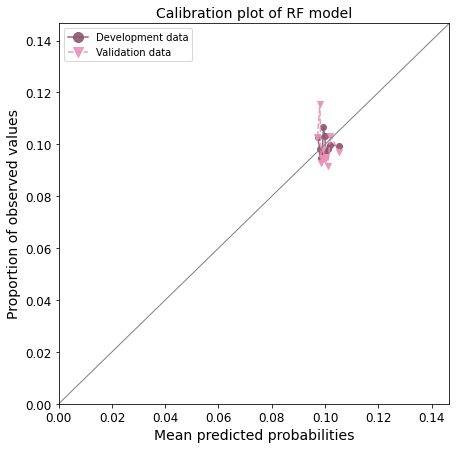

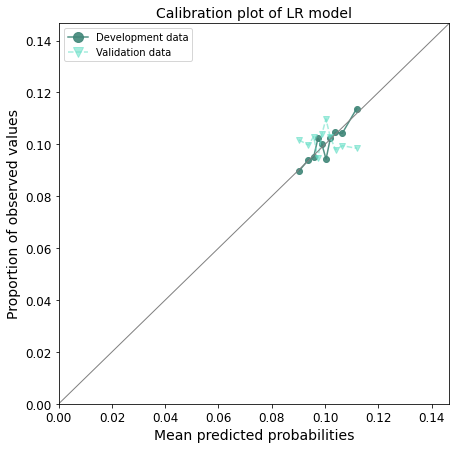

In [84]:
#build cox model for hosp prediction using non ab users' data
prob_pred_cough_cold_no_abs_incdt, prob_pred_cough_cold_no_abs_incdt_bin = cox_build('cough_cold', 'incdt', data_cough_cold_incdt, data_cough_cold_no_abs_incdt)

#build rf and lr models with deciles as predictors
prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt = lr_rf_build_risk_deciles('cough_cold', 'incdt_deciles', prob_pred_cough_cold_no_abs_incdt)

#make summary table of deciles
make_summary_table_deciles('cough_cold', 'incdt', prob_pred_enc_lr_rf_incdt)

#calibration plots of rf and lr with deciles
calibration_rf_lr('cough_cold', 'incdt_deciles', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt)

#build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt = lr_rf_build_risk_riskfactors('cough_cold', 'incdt_riskfactors', prob_pred_cough_cold_no_abs_incdt)

#calibration plots of rf and lr with risk factors
calibration_rf_lr('cough_cold', 'incdt_riskfactors', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt)

#### 5-2- prevalent

<lifelines.CoxPHFitter: fitted with 11983 total observations, 11915 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 11983
number of events observed = 68
   partial log-likelihood = -616.73
         time fit was run = 2023-06-29 10:17:43 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.58       1.78       0.46            -0.33             1.48                 0.72                 4.39
CCI_cat[T.medium]                0.89       2.44       0.47            -0.04             1.82                 0.97                 6.14
CCI_cat[T.high]                  0.66       1.93       0.56            -0.43             1.75                 0.65                 5.76
CCI_cat[T.very_high]             0.89       2.43       0.48            -0.06             1.84                 0.94                 6.27
age_cat[T.25_34]                -0.63       0.53       0.47            -1.55             0.29                 0.21                 1.34
age_cat[T.35_44]                -0.17       0.84       0.40            -0.96             0.62                 0.38                 1.85
age_cat[T.45_54]                -0.21       0.81       0.42            -1.03             0.62                 0.36                 1.86
age_cat[T.55_64]                -1.47       0.23       0.64            -2.73            -0.22                 0.07                 0.80
age_cat[T.65_74]                 0.16       1.17       0.37            -0.58             0.89                 0.56                 2.44
age_cat[T.75_more]              -0.66       0.51       0.47            -1.58             0.26                 0.20                 1.29
antibacterial_brit              -0.06       0.94       0.09            -0.24             0.11                 0.79                 1.12
bmi_cat[T.obese]                 0.42       1.52       0.53            -0.61             1.45                 0.54                 4.26
bmi_cat[T.overweight]            0.65       1.91       0.59            -0.52             1.81                 0.60                 6.10
bmi_cat[T.underweight]          -0.49       0.61       1.12            -2.69             1.70                 0.07                 5.50
bmi_cat[T.unknown]               0.12       1.13       0.57            -0.99             1.23                 0.37                 3.42
ethnicity[T.other]              -0.12       0.89       0.67            -1.44             1.20                 0.24                 3.32
ethnicity[T.unknown]             0.28       1.33       0.50            -0.69             1.26                 0.50                 3.53
ethnicity[T.white]              -0.02       0.98       0.48            -0.95             0.92                 0.39                 2.50
flu_vaccine[T.yes]              -0.50       0.61       0.52            -1.51             0.51                 0.22                 1.67
imd[T.medium]                   -0.42       0.65       0.40            -1.22             0.37                 0.30                 1.44
imd[T.unaffluent]               -0.19       0.83       0.37            -0.92             0.55                 0.40                 1.73
imd[T.unknown]                   0.22       1.24       0.51            -0.79             1.22                 0.45                 3.40
imd[T.very_affluent]            -0.30       0.74       0.38            -1.05             0.45                 0.35                 1.57
imd[T.very_unaffluent]          -0.27       0.77       0.38            -1.02             0.49                 0.36                 1.63
region[T.east_midlands]          0.26       1.29       0.6

13050


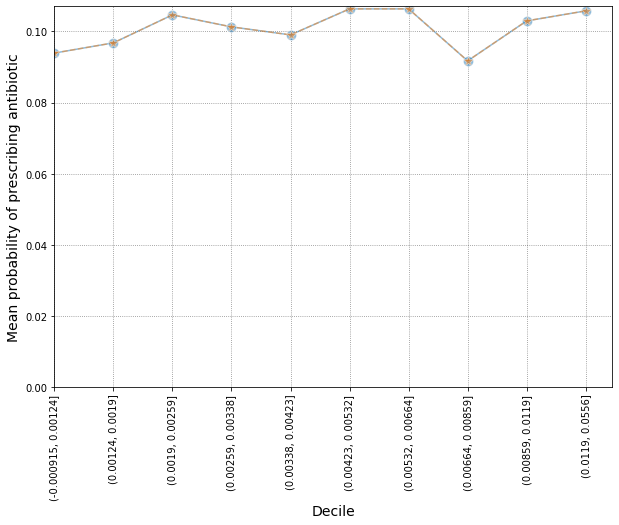


AUROC of LR for deciles with development and validation data: 0.52259 and 0.47743
AUROC of RF for deciles with development and validation data: 0.52255 and 0.47868
LR coefficients:
                                  OR  Lower CI  Upper CI
bins_(-0.000915, 0.00124]  0.104818  0.087114  0.126120
bins_(0.00124, 0.0019]     0.100083  0.082959  0.120743
bins_(0.0019, 0.00259]     0.117304  0.098524  0.139665
bins_(0.00259, 0.00338]    0.108383  0.090313  0.130067
bins_(0.00338, 0.00423]    0.118289  0.099343  0.140847
bins_(0.00423, 0.00532]    0.120000  0.100951  0.142643
bins_(0.00532, 0.00664]    0.133389  0.113046  0.157394
bins_(0.00664, 0.00859]    0.105220  0.087763  0.126150
bins_(0.00859, 0.0119]     0.120646  0.101366  0.143592
bins_(0.0119, 0.0556]      0.114971  0.096461  0.137033

RF feature importance:
                             rf_coef
bins_(0.00532, 0.00664]    0.210590
bins_(0.00124, 0.0019]     0.142171
bins_(0.00664, 0.00859]    0.113112
bins_(-0.000915, 0.00124]  0.095

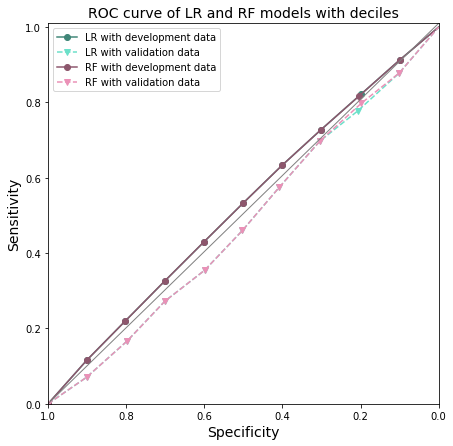

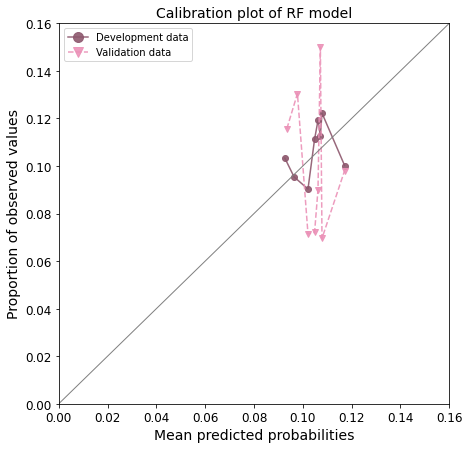

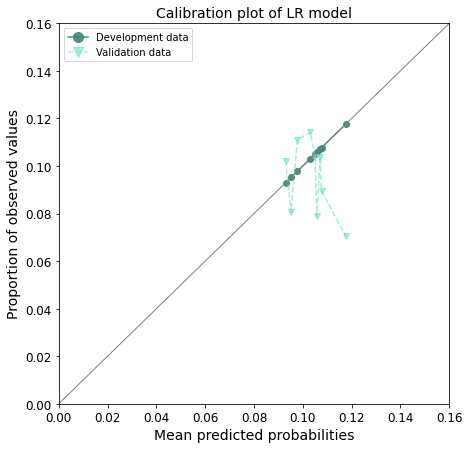


AUROC of LR for risk factors with development and validation data: 0.54887 and 0.49530
AUROC of RF for risk factors with development and validation data: 0.80288 and 0.48827
LR coefficients:
                                    OR  Lower CI  Upper CI
age_cat_15_24                0.888386       NaN       NaN
age_cat_25_34                0.984228       NaN       NaN
age_cat_35_44                0.657527       NaN       NaN
age_cat_45_54                0.882287       NaN       NaN
age_cat_55_64                0.880301       NaN       NaN
age_cat_65_74                0.980474       NaN       NaN
age_cat_75_more              0.956197       NaN       NaN
sex_female                   0.670629       NaN       NaN
sex_male                     0.624243       NaN       NaN
CCI_cat_high                 0.858632       NaN       NaN
CCI_cat_low                  0.816115       NaN       NaN
CCI_cat_medium               0.801276       NaN       NaN
CCI_cat_very_high            0.908369       NaN      

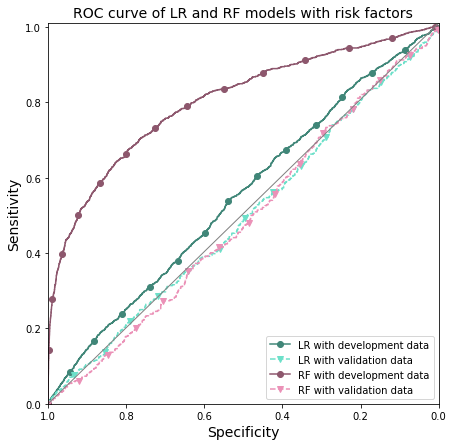

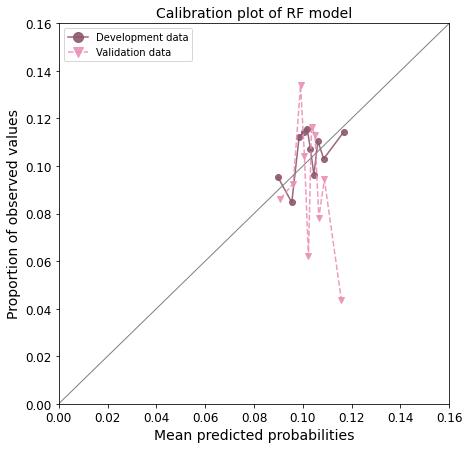

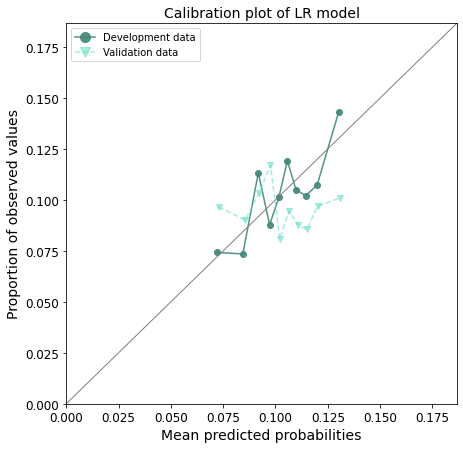

In [85]:
#build cox model for hosp prediction using non ab users' data
prob_pred_cough_cold_no_abs_prevl, prob_pred_cough_cold_no_abs_prevl_bin = cox_build('cough_cold', 'prevl', data_cough_cold_prevl, data_cough_cold_no_abs_prevl)

#build rf and lr models with deciles as predictors
prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl = lr_rf_build_risk_deciles('cough_cold', 'prevl_deciles', prob_pred_cough_cold_no_abs_prevl)

#make summary table of deciles
make_summary_table_deciles('cough_cold', 'prevl', prob_pred_enc_lr_rf_prevl)

#calibration plots of rf and lr with deciles
calibration_rf_lr('cough_cold', 'prevl_deciles', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl)

#build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl = lr_rf_build_risk_riskfactors('cough_cold', 'prevl_riskfactors', prob_pred_cough_cold_no_abs_prevl)

#calibration plots of rf and lr with risk factors
calibration_rf_lr('cough_cold', 'prevl_riskfactors', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl)

#### 5-3- stratification by time period
#### 5-3-1- incident

<lifelines.CoxPHFitter: fitted with 28541 total observations, 28370 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 28541
number of events observed = 171
   partial log-likelihood = -1738.58
         time fit was run = 2023-06-29 10:17:53 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.09       1.09       0.23            -0.37             0.55                 0.69                 1.73
CCI_cat[T.medium]               -0.01       0.99       0.26            -0.52             0.51                 0.59                 1.66
CCI_cat[T.high]                  0.34       1.40       0.29            -0.22             0.90                 0.80                 2.46
CCI_cat[T.very_high]             0.05       1.05       0.27            -0.49             0.58                 0.61                 1.79
age_cat[T.25_34]                 0.41       1.50       0.31            -0.21             1.02                 0.81                 2.77
age_cat[T.35_44]                 0.31       1.36       0.32            -0.31             0.93                 0.73                 2.53
age_cat[T.45_54]                 0.42       1.52       0.31            -0.19             1.03                 0.82                 2.80
age_cat[T.55_64]                 0.27       1.32       0.32            -0.35             0.90                 0.70                 2.47
age_cat[T.65_74]                 0.59       1.81       0.30             0.00             1.19                 1.00                 3.28
age_cat[T.75_more]               0.32       1.38       0.32            -0.30             0.94                 0.74                 2.57
antibacterial_brit              -0.03       0.97       0.05            -0.13             0.08                 0.88                 1.08
bmi_cat[T.obese]                -0.21       0.81       0.25            -0.70             0.29                 0.50                 1.33
bmi_cat[T.overweight]           -0.52       0.59       0.35            -1.20             0.16                 0.30                 1.17
bmi_cat[T.underweight]          -0.00       1.00       0.44            -0.87             0.87                 0.42                 2.38
bmi_cat[T.unknown]              -0.53       0.59       0.29            -1.09             0.03                 0.33                 1.03
ethnicity[T.other]               0.31       1.36       0.41            -0.50             1.12                 0.61                 3.07
ethnicity[T.unknown]             0.19       1.21       0.35            -0.50             0.89                 0.61                 2.43
ethnicity[T.white]               0.25       1.28       0.33            -0.40             0.89                 0.67                 2.45
flu_vaccine[T.yes]              -0.52       0.60       0.33            -1.15             0.12                 0.32                 1.13
imd[T.medium]                   -0.32       0.73       0.25            -0.82             0.18                 0.44                 1.19
imd[T.unaffluent]               -0.25       0.78       0.25            -0.73             0.24                 0.48                 1.27
imd[T.unknown]                  -0.04       0.96       0.37            -0.77             0.69                 0.46                 1.99
imd[T.very_affluent]            -0.13       0.88       0.24            -0.59             0.34                 0.55                 1.41
imd[T.very_unaffluent]          -0.10       0.90       0.24            -0.57             0.36                 0.57                 1.44
region[T.east_midlands]         -0.09       0.91       0

13069


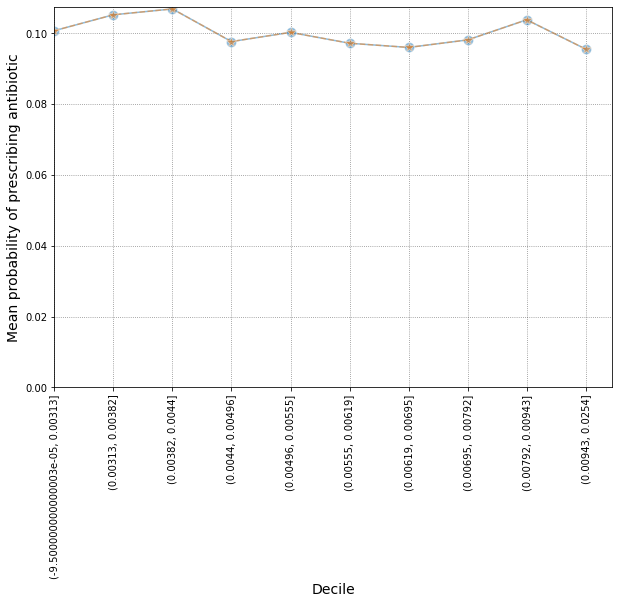


AUROC of LR for deciles with development and validation data: 0.51650 and 0.49418
AUROC of RF for deciles with development and validation data: 0.51635 and 0.49342
LR coefficients:
                                               OR  Lower CI  Upper CI
bins_(-9.500000000000003e-05, 0.00313]  0.111228  0.099059  0.124891
bins_(0.00313, 0.00382]                 0.122662  0.109615  0.137262
bins_(0.00382, 0.0044]                  0.122254  0.109324  0.136713
bins_(0.0044, 0.00496]                  0.106161  0.094341  0.119461
bins_(0.00496, 0.00555]                 0.109326  0.097286  0.122856
bins_(0.00555, 0.00619]                 0.105575  0.093787  0.118844
bins_(0.00619, 0.00695]                 0.104282  0.092627  0.117403
bins_(0.00695, 0.00792]                 0.112522  0.100224  0.126330
bins_(0.00792, 0.00943]                 0.118898  0.106271  0.133025
bins_(0.00943, 0.0254]                  0.105521  0.093721  0.118806

RF feature importance:
                                  

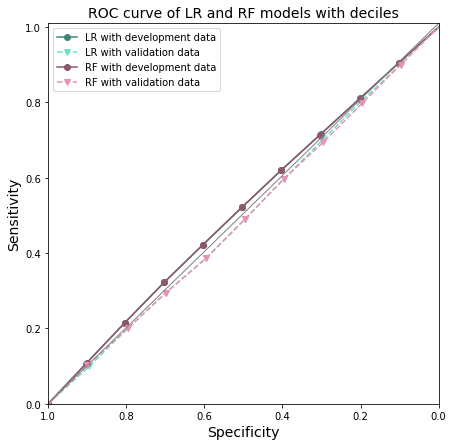

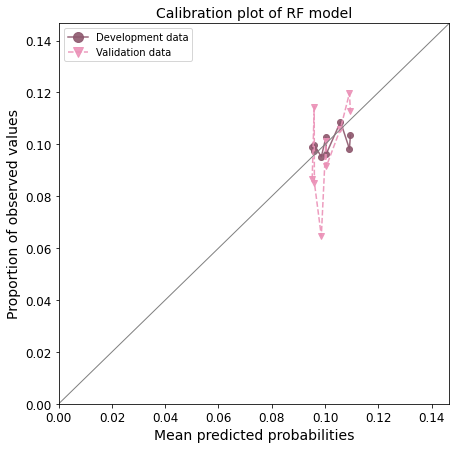

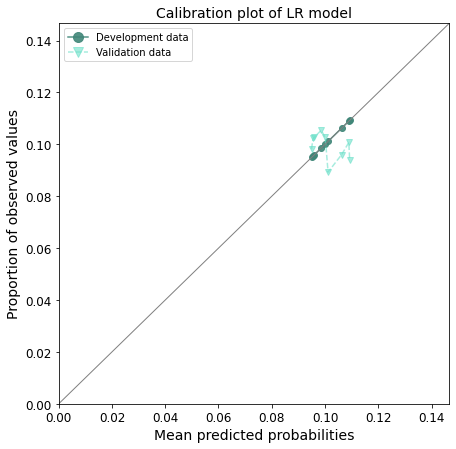

In [86]:
#build cox model for hosp prediction using non ab users' data
prob_pred_cough_cold_no_abs_incdt_prepandemic, prob_pred_cough_cold_no_abs_incdt_prepandemic_bin = cox_build('cough_cold', 'incdt_prepandemic', data_cough_cold_incdt_prepandemic, data_cough_cold_no_abs_incdt_prepandemic)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_prepandemic, data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic, rf_pred_dev_incdt_prepandemic, rf_pred_val_incdt_prepandemic = lr_rf_build_risk_deciles('cough_cold', 'incdt_prepandemic_deciles', prob_pred_cough_cold_no_abs_incdt_prepandemic)

#calibration plots of rf and lr
calibration_rf_lr('cough_cold', 'incdt_prepandemic', data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic, rf_pred_dev_incdt_prepandemic, rf_pred_val_incdt_prepandemic)

<lifelines.CoxPHFitter: fitted with 32525 total observations, 32329 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 32525
number of events observed = 196
   partial log-likelihood = -2012.67
         time fit was run = 2023-06-29 10:18:01 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.19       0.82       0.20            -0.59             0.21                 0.55                 1.23
CCI_cat[T.medium]                0.06       1.07       0.22            -0.36             0.49                 0.70                 1.63
CCI_cat[T.high]                 -0.41       0.66       0.31            -1.01             0.19                 0.36                 1.20
CCI_cat[T.very_high]            -0.28       0.76       0.25            -0.76             0.20                 0.47                 1.23
age_cat[T.25_34]                 0.30       1.35       0.27            -0.22             0.83                 0.80                 2.29
age_cat[T.35_44]                 0.04       1.04       0.29            -0.52             0.60                 0.60                 1.83
age_cat[T.45_54]                -0.12       0.89       0.30            -0.71             0.46                 0.49                 1.59
age_cat[T.55_64]                 0.43       1.54       0.26            -0.08             0.94                 0.92                 2.57
age_cat[T.65_74]                -0.12       0.89       0.30            -0.71             0.47                 0.49                 1.59
age_cat[T.75_more]               0.36       1.44       0.27            -0.16             0.89                 0.85                 2.43
antibacterial_brit               0.04       1.04       0.05            -0.06             0.13                 0.94                 1.14
bmi_cat[T.obese]                -0.07       0.93       0.28            -0.62             0.48                 0.54                 1.61
bmi_cat[T.overweight]            0.08       1.08       0.33            -0.56             0.73                 0.57                 2.07
bmi_cat[T.underweight]           0.24       1.27       0.44            -0.62             1.10                 0.54                 3.00
bmi_cat[T.unknown]               0.11       1.11       0.29            -0.46             0.68                 0.63                 1.97
ethnicity[T.other]               0.60       1.82       0.39            -0.17             1.36                 0.84                 3.91
ethnicity[T.unknown]             0.25       1.28       0.35            -0.44             0.93                 0.64                 2.54
ethnicity[T.white]               0.45       1.56       0.33            -0.20             1.09                 0.82                 2.98
flu_vaccine[T.yes]               0.01       1.01       0.24            -0.45             0.47                 0.63                 1.60
imd[T.medium]                    0.48       1.61       0.22             0.04             0.91                 1.04                 2.49
imd[T.unaffluent]                0.10       1.10       0.24            -0.37             0.57                 0.69                 1.76
imd[T.unknown]                   0.38       1.47       0.33            -0.26             1.03                 0.77                 2.79
imd[T.very_affluent]            -0.08       0.92       0.25            -0.58             0.41                 0.56                 1.50
imd[T.very_unaffluent]          -0.13       0.88       0.25            -0.62             0.37                 0.54                 1.45
region[T.east_midlands]          0.29       1.34       0

13039


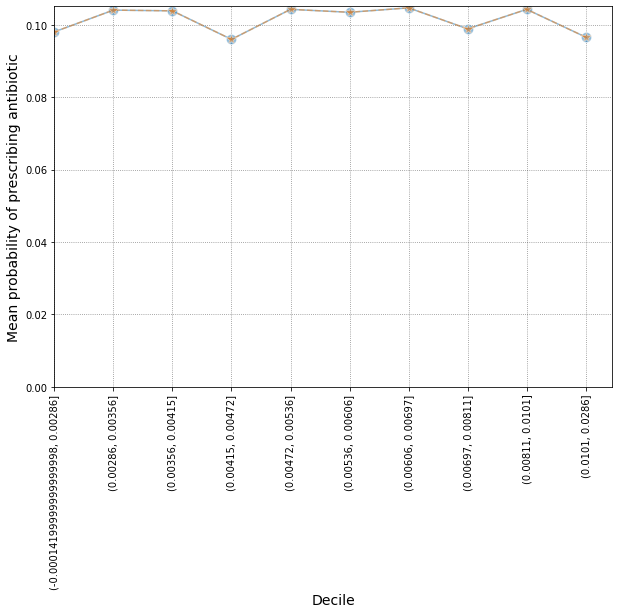


AUROC of LR for deciles with development and validation data: 0.51235 and 0.49754
AUROC of RF for deciles with development and validation data: 0.51235 and 0.49754
LR coefficients:
                                                OR  Lower CI  Upper CI
bins_(-0.00014199999999999998, 0.00286]  0.109480  0.098163  0.122102
bins_(0.00286, 0.00356]                  0.116589  0.104779  0.129731
bins_(0.00356, 0.00415]                  0.118922  0.106983  0.132194
bins_(0.00415, 0.00472]                  0.105215  0.094137  0.117597
bins_(0.00472, 0.00536]                  0.112034  0.100532  0.124853
bins_(0.00536, 0.00606]                  0.110638  0.099286  0.123289
bins_(0.00606, 0.00697]                  0.108935  0.097647  0.121528
bins_(0.00697, 0.00811]                  0.107471  0.096267  0.119979
bins_(0.00811, 0.0101]                   0.120356  0.108383  0.133652
bins_(0.0101, 0.0286]                    0.106934  0.095728  0.119451

RF feature importance:
                       

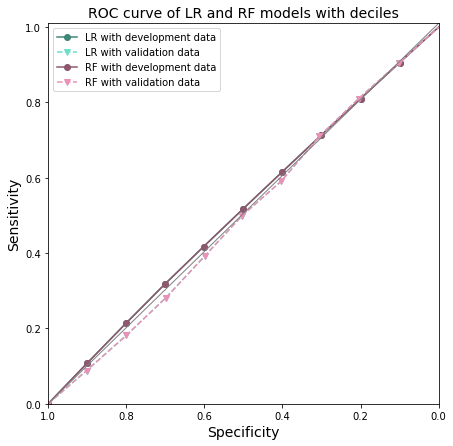

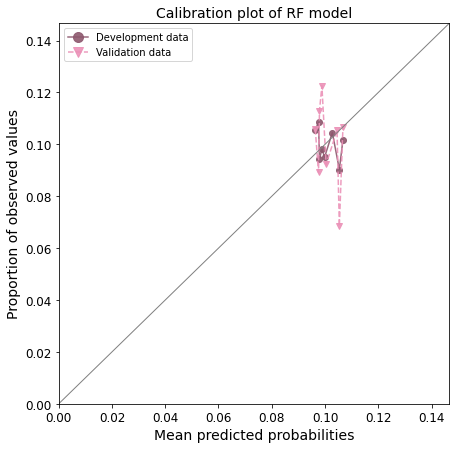

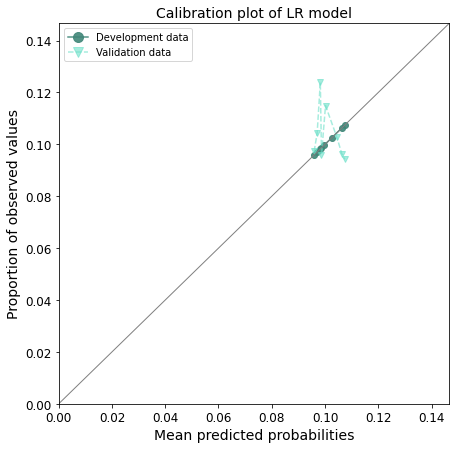

In [87]:
#build cox model for hosp prediction using non ab users' data
prob_pred_cough_cold_no_abs_incdt_during_pandemic, prob_pred_cough_cold_no_abs_incdt_during_pandemic_bin = cox_build('cough_cold', 'incdt_during_pandemic', data_cough_cold_incdt_during_pandemic, data_cough_cold_no_abs_incdt_during_pandemic)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_during_pandemic, data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic, rf_pred_dev_incdt_during_pandemic, rf_pred_val_incdt_during_pandemic = lr_rf_build_risk_deciles('cough_cold', 'incdt_during_pandemic_deciles', prob_pred_cough_cold_no_abs_incdt_during_pandemic)

#calibration plots of rf and lr
calibration_rf_lr('cough_cold', 'incdt_during_pandemic', data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic, rf_pred_dev_incdt_during_pandemic, rf_pred_val_incdt_during_pandemic)

<lifelines.CoxPHFitter: fitted with 46382 total observations, 46056 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 46382
number of events observed = 326
   partial log-likelihood = -3476.23
         time fit was run = 2023-06-29 10:18:09 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.03       1.03       0.17            -0.30             0.37                 0.74                 1.45
CCI_cat[T.medium]                0.02       1.02       0.19            -0.35             0.39                 0.70                 1.48
CCI_cat[T.high]                  0.15       1.16       0.22            -0.28             0.58                 0.75                 1.78
CCI_cat[T.very_high]             0.31       1.36       0.19            -0.06             0.67                 0.94                 1.96
age_cat[T.25_34]                -0.02       0.98       0.20            -0.41             0.37                 0.66                 1.45
age_cat[T.35_44]                -0.32       0.72       0.22            -0.74             0.10                 0.48                 1.11
age_cat[T.45_54]                -0.30       0.74       0.22            -0.72             0.12                 0.49                 1.13
age_cat[T.55_64]                 0.04       1.04       0.20            -0.35             0.43                 0.71                 1.53
age_cat[T.65_74]                -0.20       0.82       0.21            -0.62             0.21                 0.54                 1.23
age_cat[T.75_more]               0.07       1.07       0.19            -0.31             0.45                 0.73                 1.57
antibacterial_brit               0.02       1.02       0.04            -0.06             0.09                 0.94                 1.10
bmi_cat[T.obese]                -0.13       0.87       0.20            -0.52             0.25                 0.60                 1.28
bmi_cat[T.overweight]           -0.22       0.80       0.25            -0.71             0.27                 0.49                 1.31
bmi_cat[T.underweight]           0.03       1.03       0.34            -0.64             0.69                 0.53                 2.00
bmi_cat[T.unknown]              -0.23       0.79       0.21            -0.65             0.18                 0.52                 1.20
ethnicity[T.other]              -0.37       0.69       0.29            -0.94             0.20                 0.39                 1.22
ethnicity[T.unknown]            -0.38       0.69       0.22            -0.81             0.06                 0.44                 1.06
ethnicity[T.white]              -0.12       0.89       0.20            -0.51             0.27                 0.60                 1.31
flu_vaccine[T.yes]              -0.11       0.89       0.19            -0.50             0.27                 0.61                 1.31
imd[T.medium]                   -0.04       0.96       0.17            -0.38             0.30                 0.68                 1.35
imd[T.unaffluent]                0.07       1.07       0.17            -0.27             0.40                 0.77                 1.49
imd[T.unknown]                  -0.80       0.45       0.37            -1.53            -0.07                 0.22                 0.93
imd[T.very_affluent]            -0.14       0.87       0.18            -0.49             0.21                 0.61                 1.23
imd[T.very_unaffluent]          -0.16       0.85       0.18            -0.51             0.19                 0.60                 1.21
region[T.east_midlands]         -0.01       0.99       0

13066


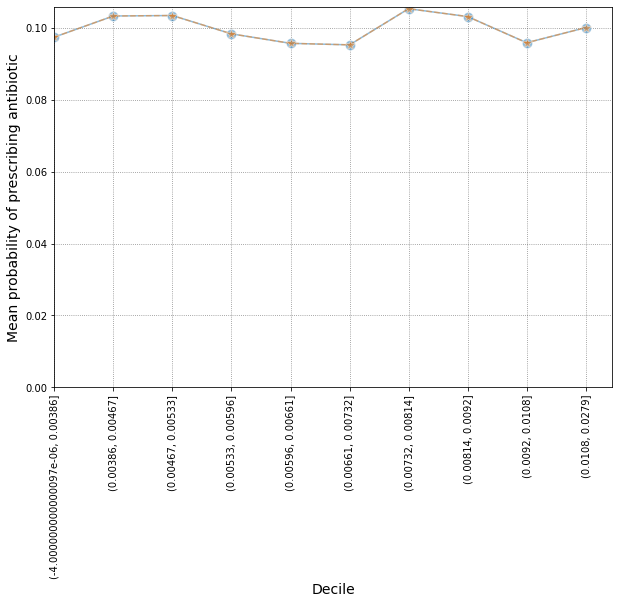


AUROC of LR for deciles with development and validation data: 0.51144 and 0.50369
AUROC of RF for deciles with development and validation data: 0.51143 and 0.50491
LR coefficients:
                                               OR  Lower CI  Upper CI
bins_(-4.000000000000097e-06, 0.00386]  0.110706  0.101083  0.121245
bins_(0.00386, 0.00467]                 0.109521  0.099907  0.120059
bins_(0.00467, 0.00533]                 0.115393  0.105497  0.126217
bins_(0.00533, 0.00596]                 0.107986  0.098496  0.118391
bins_(0.00596, 0.00661]                 0.107477  0.098060  0.117798
bins_(0.00661, 0.00732]                 0.099063  0.090059  0.108966
bins_(0.00732, 0.00814]                 0.117736  0.107736  0.128664
bins_(0.00814, 0.0092]                  0.111931  0.102196  0.122592
bins_(0.0092, 0.0108]                   0.108541  0.098990  0.119012
bins_(0.0108, 0.0279]                   0.110556  0.100884  0.121155

RF feature importance:
                                  

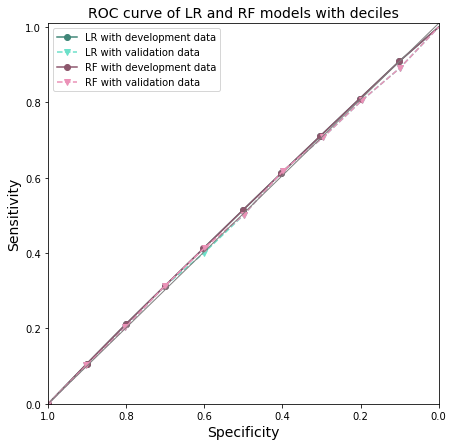

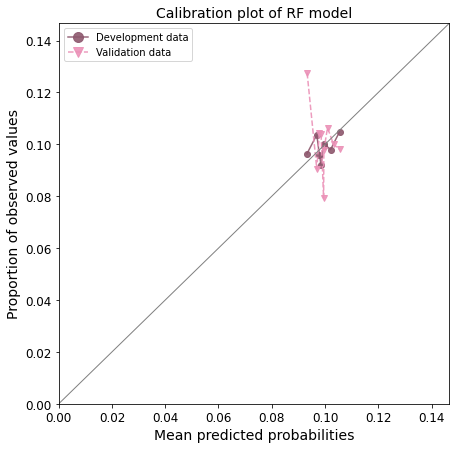

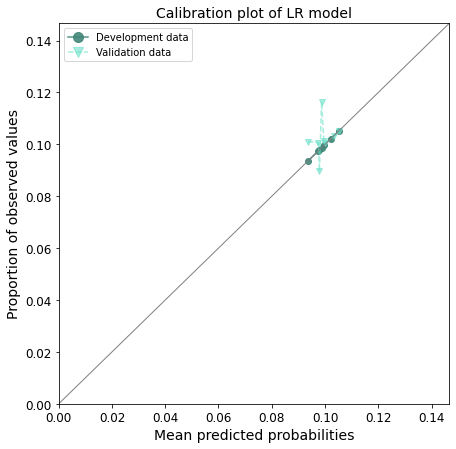

In [88]:
#build cox model for hosp prediction using non ab users' data
prob_pred_cough_cold_no_abs_incdt_post_2nd_lockdown, prob_pred_cough_cold_no_abs_incdt_post_2nd_lockdown_bin = cox_build('cough_cold', 'incdt_post_2nd_lockdown', data_cough_cold_incdt_post_2nd_lockdown, data_cough_cold_no_abs_incdt_post_2nd_lockdown)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_post_2nd_lockdown, data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown, rf_pred_dev_incdt_post_2nd_lockdown, rf_pred_val_incdt_post_2nd_lockdown = lr_rf_build_risk_deciles('cough_cold', 'incdt_post_2nd_lockdown_deciles', prob_pred_cough_cold_no_abs_incdt_post_2nd_lockdown)

#calibration plots of rf and lr
calibration_rf_lr('cough_cold', 'incdt_post_2nd_lockdown', data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown, rf_pred_dev_incdt_post_2nd_lockdown, rf_pred_val_incdt_post_2nd_lockdown)

#### 5-3-2- prevalent

<lifelines.CoxPHFitter: fitted with 3131 total observations, 3115 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 3131
number of events observed = 16
   partial log-likelihood = -110.62
         time fit was run = 2023-06-29 10:18:20 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.35       1.42       1.16            -1.93             2.62                 0.15                13.77
CCI_cat[T.medium]                1.62       5.07       1.09            -0.51             3.76                 0.60                42.83
CCI_cat[T.high]                -16.98       0.00    6551.08        -12856.87         12822.91                 0.00                  inf
CCI_cat[T.very_high]             1.76       5.84       1.09            -0.36             3.89                 0.69                49.07
age_cat[T.25_34]                 0.52       1.69       1.24            -1.91             2.95                 0.15                19.16
age_cat[T.35_44]               -17.26       0.00    5036.47         -9888.56          9854.04                 0.00                  inf
age_cat[T.45_54]                 1.29       3.63       1.14            -0.94             3.52                 0.39                33.83
age_cat[T.55_64]                 1.28       3.61       1.13            -0.93             3.50                 0.39                33.11
age_cat[T.65_74]                 1.13       3.11       1.17            -1.16             3.42                 0.32                30.66
age_cat[T.75_more]               0.60       1.82       1.24            -1.83             3.03                 0.16                20.64
antibacterial_brit              -0.14       0.87       0.20            -0.52             0.24                 0.59                 1.27
bmi_cat[T.obese]                -0.81       0.44       0.84            -2.45             0.83                 0.09                 2.29
bmi_cat[T.overweight]           -0.14       0.87       0.94            -1.97             1.70                 0.14                 5.48
bmi_cat[T.underweight]          -0.04       0.96       1.27            -2.52             2.44                 0.08                11.52
bmi_cat[T.unknown]              -0.51       0.60       0.89            -2.25             1.22                 0.11                 3.40
ethnicity[T.other]              17.62   4.47e+07    6813.82        -13337.23         13372.46                 0.00                  inf
ethnicity[T.unknown]            17.91   5.99e+07    6813.82        -13336.94         13372.75                 0.00                  inf
ethnicity[T.white]              17.66   4.65e+07    6813.82        -13337.19         13372.50                 0.00                  inf
flu_vaccine[T.yes]               0.32       1.38       0.78            -1.21             1.85                 0.30                 6.37
imd[T.medium]                   -0.91       0.40       0.86            -2.59             0.77                 0.08                 2.15
imd[T.unaffluent]               -0.43       0.65       0.75            -1.90             1.04                 0.15                 2.83
imd[T.unknown]                 -18.41       0.00    8310.87        -16307.41         16270.59                 0.00                  inf
imd[T.very_affluent]            -0.97       0.38       0.85            -2.64             0.70                 0.07                 2.01
imd[T.very_unaffluent]          -0.17       0.84       0.69            -1.53             1.19                 0.22                 3.28
region[T.east_midlands]          0.11       1.12       1.43  

13154


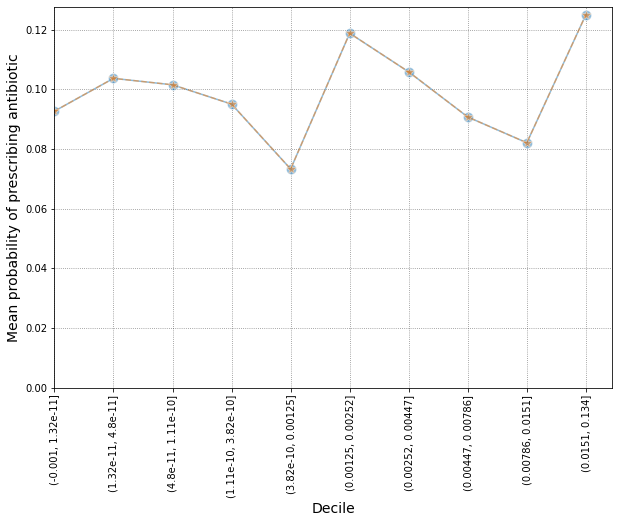


AUROC of LR for deciles with development and validation data: 0.55763 and 0.50761
AUROC of RF for deciles with development and validation data: 0.55755 and 0.50551
LR coefficients:
                                  OR  Lower CI  Upper CI
bins_(-0.001, 1.32e-11]    0.101266  0.070397  0.145670
bins_(0.00125, 0.00252]    0.154639  0.112972  0.211674
bins_(0.00252, 0.00447]    0.126214  0.090460  0.176098
bins_(0.00447, 0.00786]    0.096154  0.066109  0.139854
bins_(0.00786, 0.0151]     0.094340  0.064882  0.137172
bins_(0.0151, 0.134]       0.148734  0.109480  0.202062
bins_(1.11e-10, 3.82e-10]  0.099379  0.069107  0.142911
bins_(1.32e-11, 4.8e-11]   0.107143  0.074826  0.153417
bins_(3.82e-10, 0.00125]   0.077170  0.050947  0.116891
bins_(4.8e-11, 1.11e-10]   0.125392  0.090260  0.174199

RF feature importance:
                             rf_coef
bins_(0.00125, 0.00252]    0.201150
bins_(0.0151, 0.134]       0.180630
bins_(3.82e-10, 0.00125]   0.177945
bins_(0.00786, 0.0151]     0.077

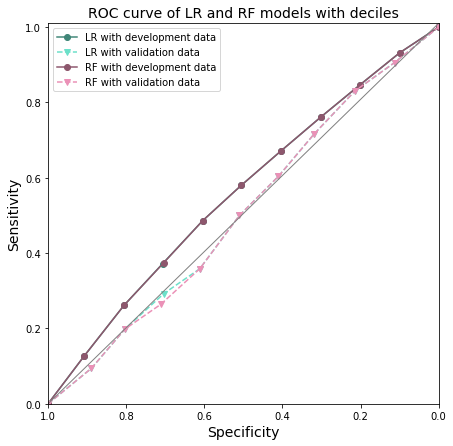

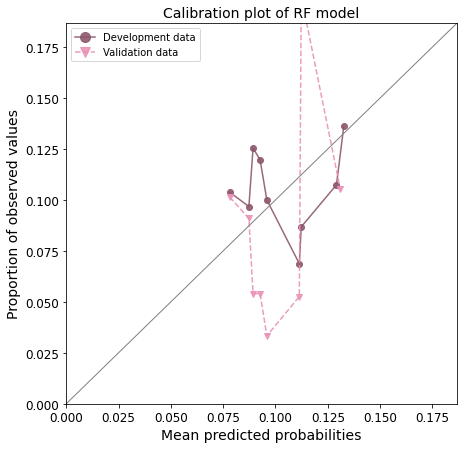

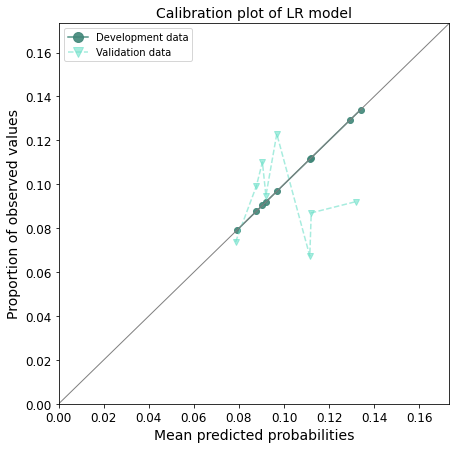

In [89]:
#build cox model for hosp prediction using non ab users' data
prob_pred_cough_cold_no_abs_prevl_prepandemic, prob_pred_cough_cold_no_abs_prevl_prepandemic_bin = cox_build('cough_cold', 'prevl_prepandemic', data_cough_cold_prevl_prepandemic, data_cough_cold_no_abs_prevl_prepandemic)

#build rf and lr models
prob_pred_enc_lr_rf_prevl_prepandemic, data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic, rf_pred_dev_prevl_prepandemic, rf_pred_val_prevl_prepandemic = lr_rf_build_risk_deciles('cough_cold', 'prevl_prepandemic_deciles', prob_pred_cough_cold_no_abs_prevl_prepandemic)

#calibration plots of rf and lr
calibration_rf_lr('cough_cold', 'prevl_prepandemic', data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic, rf_pred_dev_prevl_prepandemic, rf_pred_val_prevl_prepandemic)

<lifelines.CoxPHFitter: fitted with 3609 total observations, 3587 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 3609
number of events observed = 22
   partial log-likelihood = -165.96
         time fit was run = 2023-06-29 10:18:26 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.99       2.69       0.77            -0.53             2.50                 0.59                12.23
CCI_cat[T.medium]                0.17       1.18       0.92            -1.63             1.97                 0.20                 7.16
CCI_cat[T.high]                  1.02       2.78       0.92            -0.79             2.83                 0.45                17.02
CCI_cat[T.very_high]             0.46       1.59       0.92            -1.34             2.27                 0.26                 9.64
age_cat[T.25_34]                -0.30       0.74       0.92            -2.10             1.50                 0.12                 4.49
age_cat[T.35_44]                 0.36       1.43       0.77            -1.15             1.86                 0.32                 6.45
age_cat[T.45_54]                -1.00       0.37       1.16            -3.27             1.28                 0.04                 3.59
age_cat[T.55_64]                -0.41       0.66       0.92            -2.22             1.40                 0.11                 4.05
age_cat[T.65_74]                 0.97       2.64       0.68            -0.37             2.31                 0.69                10.09
age_cat[T.75_more]              -0.42       0.66       0.92            -2.22             1.38                 0.11                 3.98
antibacterial_brit              -0.16       0.85       0.16            -0.48             0.16                 0.62                 1.17
bmi_cat[T.obese]                 0.73       2.08       1.04            -1.31             2.77                 0.27                16.03
bmi_cat[T.overweight]            0.41       1.51       1.23            -2.00             2.83                 0.13                16.92
bmi_cat[T.underweight]         -16.34       0.00    5880.92        -11542.73         11510.05                 0.00                  inf
bmi_cat[T.unknown]               0.50       1.65       1.10            -1.66             2.66                 0.19                14.29
ethnicity[T.other]              16.37   1.29e+07    3715.47         -7265.82          7298.56                 0.00                  inf
ethnicity[T.unknown]            16.86   2.10e+07    3715.47         -7265.33          7299.05                 0.00                  inf
ethnicity[T.white]              17.13   2.76e+07    3715.47         -7265.06          7299.33                 0.00                  inf
flu_vaccine[T.yes]               0.05       1.05       0.75            -1.42             1.53                 0.24                 4.60
imd[T.medium]                    0.04       1.04       0.64            -1.22             1.30                 0.30                 3.66
imd[T.unaffluent]               -0.02       0.98       0.64            -1.27             1.24                 0.28                 3.45
imd[T.unknown]                  -0.16       0.85       1.11            -2.33             2.00                 0.10                 7.42
imd[T.very_affluent]            -0.51       0.60       0.74            -1.96             0.94                 0.14                 2.57
imd[T.very_unaffluent]          -0.48       0.62       0.74            -1.92             0.97                 0.15                 2.63
region[T.east_midlands]          0.03       1.03       1.42  

13104


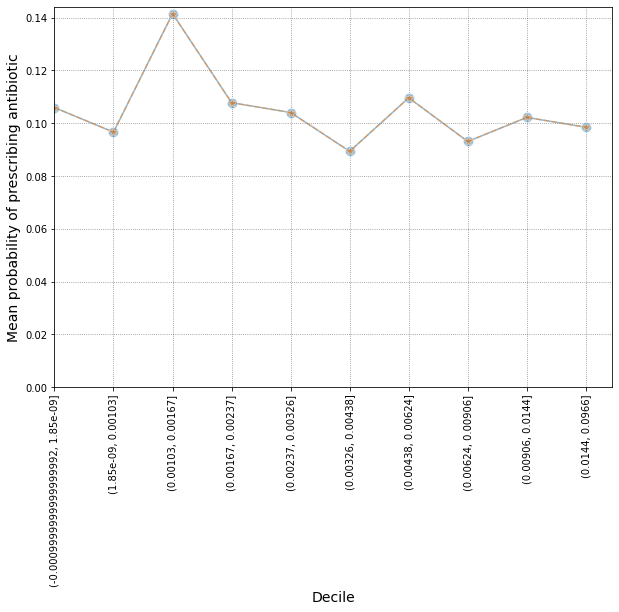


AUROC of LR for deciles with development and validation data: 0.54679 and 0.49065
AUROC of RF for deciles with development and validation data: 0.54637 and 0.49509
LR coefficients:
                                                OR  Lower CI  Upper CI
bins_(-0.0009999999999999992, 1.85e-09]  0.134986  0.100171  0.181902
bins_(0.00103, 0.00167]                  0.179941  0.137008  0.236328
bins_(0.00167, 0.00237]                  0.126404  0.092703  0.172359
bins_(0.00237, 0.00326]                  0.110497  0.079712  0.153172
bins_(0.00326, 0.00438]                  0.093583  0.066181  0.132330
bins_(0.00438, 0.00624]                  0.116618  0.084052  0.161802
bins_(0.00624, 0.00906]                  0.104520  0.074496  0.146645
bins_(0.00906, 0.0144]                   0.108696  0.078433  0.150635
bins_(0.0144, 0.0966]                    0.111111  0.080470  0.153421
bins_(1.85e-09, 0.00103]                 0.103448  0.074395  0.143847

RF feature importance:
                       

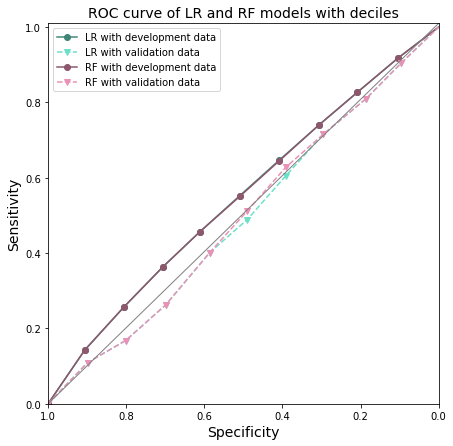

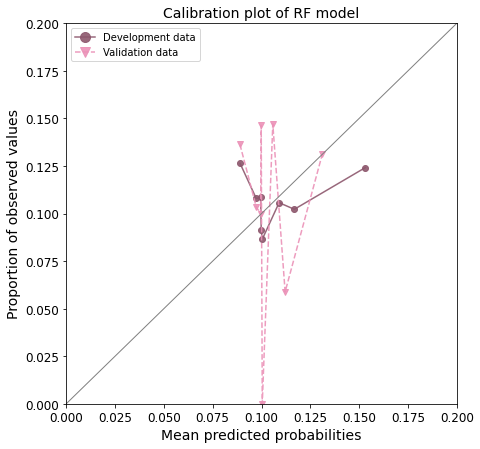

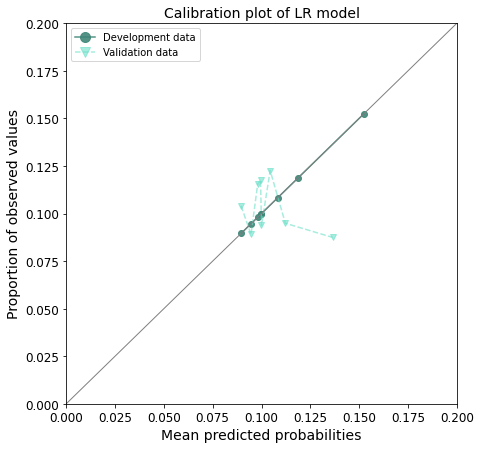

In [90]:
#build cox model for hosp prediction using non ab users' data
prob_pred_cough_cold_no_abs_prevl_during_pandemic, prob_pred_cough_cold_no_abs_prevl_during_pandemic_bin = cox_build('cough_cold', 'prevl_during_pandemic', data_cough_cold_prevl_during_pandemic, data_cough_cold_no_abs_prevl_during_pandemic)

#build rf and lr models
prob_pred_enc_lr_rf_prevl_during_pandemic, data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic, rf_pred_dev_prevl_during_pandemic, rf_pred_val_prevl_during_pandemic = lr_rf_build_risk_deciles('cough_cold', 'prevl_during_pandemic_deciles', prob_pred_cough_cold_no_abs_prevl_during_pandemic)

#calibration plots of rf and lr
calibration_rf_lr('cough_cold', 'prevl_during_pandemic', data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic, rf_pred_dev_prevl_during_pandemic, rf_pred_val_prevl_during_pandemic)

<lifelines.CoxPHFitter: fitted with 5242 total observations, 5205 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 5242
number of events observed = 37
   partial log-likelihood = -298.74
         time fit was run = 2023-06-29 10:18:34 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.14       1.15       0.54            -0.91             1.19                 0.40                 3.29
CCI_cat[T.medium]                0.32       1.38       0.57            -0.80             1.45                 0.45                 4.26
CCI_cat[T.high]                  0.40       1.49       0.67            -0.92             1.72                 0.40                 5.61
CCI_cat[T.very_high]             0.47       1.59       0.57            -0.66             1.59                 0.52                 4.90
age_cat[T.25_34]                -1.22       0.29       0.66            -2.52             0.07                 0.08                 1.08
age_cat[T.35_44]                -0.59       0.55       0.52            -1.61             0.42                 0.20                 1.53
age_cat[T.45_54]                -0.51       0.60       0.52            -1.53             0.51                 0.22                 1.66
age_cat[T.55_64]                -2.36       0.09       1.05            -4.42            -0.30                 0.01                 0.74
age_cat[T.65_74]                -0.31       0.73       0.48            -1.25             0.62                 0.29                 1.87
age_cat[T.75_more]              -1.19       0.30       0.66            -2.49             0.10                 0.08                 1.11
antibacterial_brit              -0.08       0.92       0.12            -0.32             0.16                 0.73                 1.17
bmi_cat[T.obese]                -0.40       0.67       0.56            -1.49             0.70                 0.23                 2.01
bmi_cat[T.overweight]            0.24       1.27       0.63            -1.00             1.48                 0.37                 4.38
bmi_cat[T.underweight]         -16.34       0.00    2780.11         -5465.25          5432.57                 0.00                  inf
bmi_cat[T.unknown]              -0.53       0.59       0.62            -1.74             0.68                 0.18                 1.98
ethnicity[T.other]               0.07       1.07       0.83            -1.55             1.69                 0.21                 5.42
ethnicity[T.unknown]             0.13       1.14       0.66            -1.15             1.42                 0.32                 4.15
ethnicity[T.white]              -0.11       0.90       0.63            -1.34             1.12                 0.26                 3.06
flu_vaccine[T.yes]               0.24       1.27       0.53            -0.81             1.29                 0.45                 3.62
imd[T.medium]                   -0.85       0.43       0.53            -1.90             0.20                 0.15                 1.22
imd[T.unaffluent]               -0.87       0.42       0.54            -1.92             0.18                 0.15                 1.19
imd[T.unknown]                   0.26       1.30       0.58            -0.88             1.40                 0.41                 4.07
imd[T.very_affluent]            -1.12       0.33       0.58            -2.25             0.02                 0.11                 1.02
imd[T.very_unaffluent]          -0.53       0.59       0.48            -1.46             0.41                 0.23                 1.51
region[T.east_midlands]          0.46       1.59       0.92  

13065


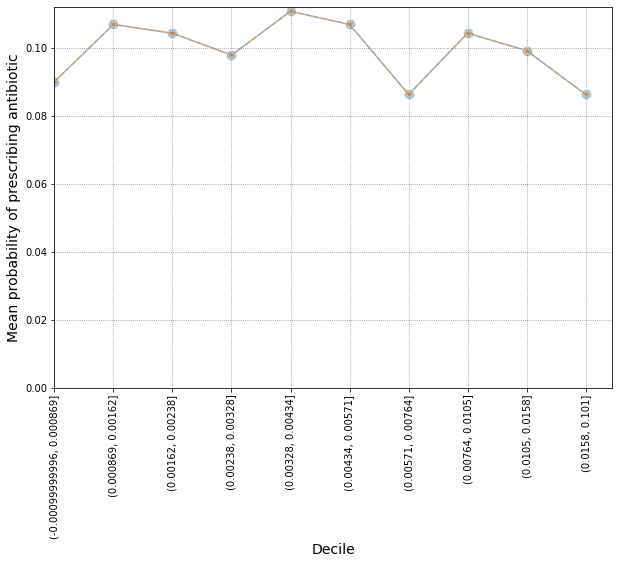


AUROC of LR for deciles with development and validation data: 0.53494 and 0.49502
AUROC of RF for deciles with development and validation data: 0.53490 and 0.49405
LR coefficients:
                                        OR  Lower CI  Upper CI
bins_(-0.00099999996, 0.000869]  0.101818  0.077344  0.134036
bins_(0.000869, 0.00162]         0.123596  0.095706  0.159612
bins_(0.00162, 0.00238]          0.119093  0.091714  0.154644
bins_(0.00238, 0.00328]          0.113949  0.086845  0.149512
bins_(0.00328, 0.00434]          0.140530  0.109227  0.180802
bins_(0.00434, 0.00571]          0.116323  0.089423  0.151315
bins_(0.00571, 0.00764]          0.093625  0.069431  0.126252
bins_(0.00764, 0.0105]           0.115888  0.089093  0.150742
bins_(0.0105, 0.0158]            0.100379  0.075682  0.133135
bins_(0.0158, 0.101]             0.091429  0.068034  0.122867

RF feature importance:
                                   rf_coef
bins_(0.00328, 0.00434]          0.217206
bins_(0.0158, 0.101]      

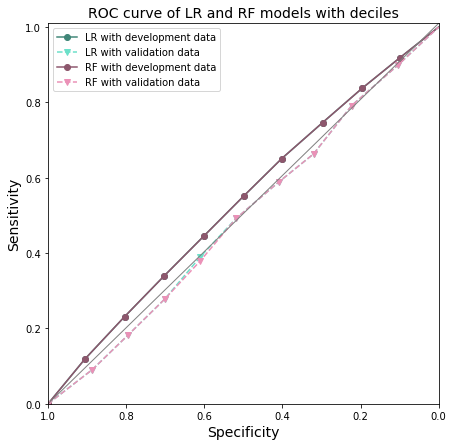

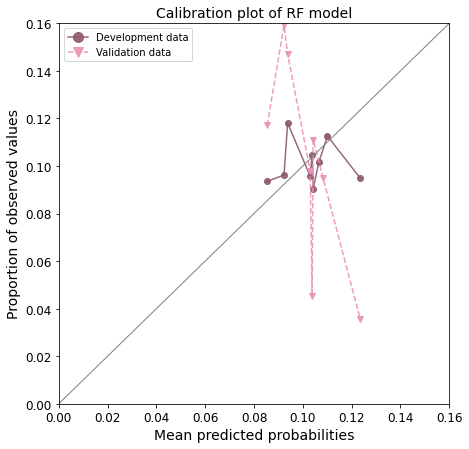

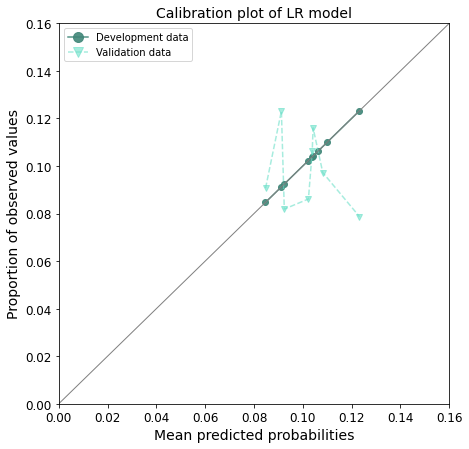

In [91]:
#build cox model for hosp prediction using non ab users' data
prob_pred_cough_cold_no_abs_prevl_post_2nd_lockdown, prob_pred_cough_cold_no_abs_prevl_post_2nd_lockdown_bin = cox_build('cough_cold', 'prevl_post_2nd_lockdown', data_cough_cold_prevl_post_2nd_lockdown, data_cough_cold_no_abs_prevl_post_2nd_lockdown)

#build rf and lr models
prob_pred_enc_lr_rf_prevl_post_2nd_lockdown, data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown, rf_pred_dev_prevl_post_2nd_lockdown, rf_pred_val_prevl_post_2nd_lockdown = lr_rf_build_risk_deciles('cough_cold', 'prevl_post_2nd_lockdown_deciles', prob_pred_cough_cold_no_abs_prevl_post_2nd_lockdown)

#calibration plots of rf and lr
calibration_rf_lr('cough_cold', 'prevl_post_2nd_lockdown', data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown, rf_pred_dev_prevl_post_2nd_lockdown, rf_pred_val_prevl_post_2nd_lockdown)